In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks

**My goal:**
<p>Ground contact time (how long your foot is on the ground), and Peak vertical acceleration on landing.</p>

In [2]:
df = pd.read_csv('Bib_skoky\David-50-pokus01\Xsens_DOT_2_D422CD006474_20250409_104913.csv', skiprows=7, sep=",")
df.head(10)

,PacketCounter,SampleTimeFine,Euler_X,Euler_Y,Euler_Z,Acc_X,Acc_Y,Acc_Z,Gyr_X,Gyr_Y,Gyr_Z
0,0,1607843351,36.775726,-86.671394,13.272182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1607860018,36.780804,-86.665871,13.271647,9.823255,0.214549,0.535771,0.820381,-0.701801,0.462905
2,2,1607876685,36.773621,-86.652451,13.283276,9.854137,0.205249,0.615227,0.791394,-0.307372,0.219475
3,3,1607893352,36.821060,-86.644218,13.250474,9.832771,0.222084,0.596367,0.891143,-0.664105,0.246138
4,4,1607910019,36.734947,-86.640244,13.332602,9.857924,0.243331,0.521637,0.461791,-0.612566,0.773894
5,5,1607926686,36.645306,-86.633438,13.421897,9.823310,0.207531,0.538723,0.466875,-0.464153,0.674888
6,6,1607943353,36.555939,-86.625130,13.514371,9.784780,0.209336,0.530744,0.548983,-0.386809,0.623080
7,7,1607960020,36.488739,-86.619278,13.584394,9.770255,0.244711,0.551879,0.696422,-0.549360,0.660936
8,8,1607976687,36.497688,-86.625015,13.576014,9.741570,0.231114,0.558532,0.557620,-1.271645,0.850335
9,9,1607993354,36.557137,-86.628326,13.517493,9.759730,0.224089,0.556158,0.675772,-1.254036,0.624943


In [3]:
df.describe()   

,PacketCounter,SampleTimeFine,Euler_X,Euler_Y,Euler_Z,Acc_X,Acc_Y,Acc_Z,Gyr_X,Gyr_Y,Gyr_Z
count,672.000000,6.720000e+02,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,335.500000,1.613435e+09,22.640520,-84.096835,24.063761,9.744938,0.117191,1.088022,-0.114339,-0.945516,0.231364
std,194.133974,3.235631e+06,19.051348,4.889810,16.912265,5.866193,1.182763,3.067529,16.972732,30.346702,9.994962
min,0.000000,1.607843e+09,-29.075811,-86.880089,5.841342,-17.715855,-10.045979,-7.115994,-150.107513,-340.759583,-92.757011
25%,167.750000,1.610639e+09,10.542409,-86.716644,9.529317,9.774590,0.123954,0.462086,-0.593726,-1.925177,0.327521
50%,335.500000,1.613435e+09,16.616342,-86.474781,25.971560,9.808512,0.216319,0.527105,0.513163,-1.002334,0.675055
75%,503.250000,1.616231e+09,40.421697,-83.752531,31.667243,9.839744,0.253115,0.961803,1.202031,-0.237854,1.234028
max,671.000000,1.619027e+09,44.069973,-59.816448,73.895164,97.041138,11.857512,36.169914,104.568871,264.055389,54.046719


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PacketCounter   672 non-null    int64  
 1   SampleTimeFine  672 non-null    int64  
 2   Euler_X         672 non-null    float64
 3   Euler_Y         672 non-null    float64
 4   Euler_Z         672 non-null    float64
 5   Acc_X           672 non-null    float64
 6   Acc_Y           672 non-null    float64
 7   Acc_Z           672 non-null    float64
 8   Gyr_X           672 non-null    float64
 9   Gyr_Y           672 non-null    float64
 10  Gyr_Z           672 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 57.9 KB


In [5]:
df.isnull().sum()

PacketCounter     0
SampleTimeFine    0
Euler_X           0
Euler_Y           0
Euler_Z           0
Acc_X             0
Acc_Y             0
Acc_Z             0
Gyr_X             0
Gyr_Y             0
Gyr_Z             0
dtype: int64

**Right now I  only have SampleTimeFine tick counts. I have to convert it into real time axis**
<p> SampleTimeFine Contains the timestamp of an output expressed in 1MHz clock ticks of the device’s local clock. <br>The unit of the SampleTimeFine is microsecond. If the data output rate is 60 Hz, the time interval between two SampleTimeFine is 16667 µs.</p>


In [6]:
# I zero the clock at the first row, this makes all subsequent rows relative to test start
df['real_ticks'] = df['SampleTimeFine'] - df['SampleTimeFine'].iloc[0] 

# Converting the ticks to seconds and milliseconds
df['time_s'] = df['real_ticks'] * 1e-6

# Convert seconds to milliseconds
df['time_ms'] = df['time_s'] * 1000
#  show the actual intervals between samples
df['delta_ms'] = df['time_ms'].diff()

In [7]:
df[['time_ms', 'time_s', 'delta_ms']].describe()

,time_ms,time_s,delta_ms
count,672.000000,672.000000,6.710000e+02
mean,5591.778500,5.591778,1.666700e+01
std,3235.630951,3.235631,5.193370e-13
min,0.000000,0.000000,1.666700e+01
25%,2795.889250,2.795889,1.666700e+01
50%,5591.778500,5.591778,1.666700e+01
75%,8387.667750,8.387668,1.666700e+01
max,11183.557000,11.183557,1.666700e+01


**Delta_ms is  16.667 ms,  IMU was sampling at  60 Hz**

In [8]:
# Frequency Calculation:
# Find out how fast they sampled
mean_delta_ms = df['delta_ms'].mean()
fs = 1000.0 / mean_delta_ms
print(f"Sampling frequency: {fs} Hz")

Sampling frequency: 59.99880002399953 Hz


In [9]:
# 1. Find out how fast we sampled
mean_delta_ms = df['delta_ms'].mean()

In [10]:
print('Z axis acceleration statistics of pelvis IMU vs Time in Seconds, Milliseconds and Delta in milliseconds:\n')
df[['time_ms', 'time_s', 'delta_ms', 'Acc_Z']].describe()

Z axis acceleration statistics of pelvis IMU vs Time in Seconds, Milliseconds and Delta in milliseconds:



,time_ms,time_s,delta_ms,Acc_Z
count,672.000000,672.000000,6.710000e+02,672.000000
mean,5591.778500,5.591778,1.666700e+01,1.088022
std,3235.630951,3.235631,5.193370e-13,3.067529
min,0.000000,0.000000,1.666700e+01,-7.115994
25%,2795.889250,2.795889,1.666700e+01,0.462086
50%,5591.778500,5.591778,1.666700e+01,0.527105
75%,8387.667750,8.387668,1.666700e+01,0.961803
max,11183.557000,11.183557,1.666700e+01,36.169914


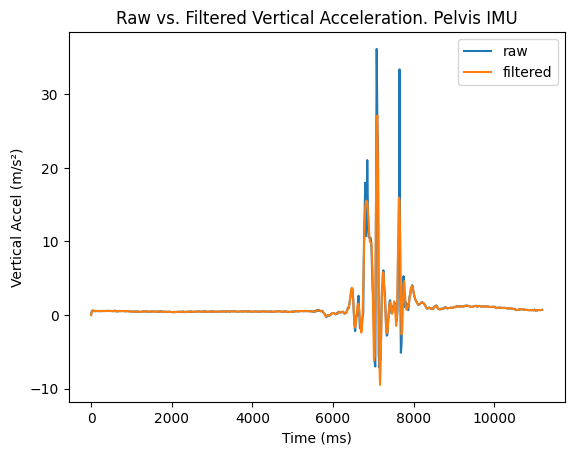

In [ ]:
# Estimate my sampling frequency from the mean delta_ms
mean_delta_ms = df['delta_ms'].mean()
#  delta_ms is in milliseconds between samples (16.667 ms for 60 Hz data).
fs = 1000.0 / mean_delta_ms
# 1000 ms/s ÷ (ms/sample) = samples per second (Hz).

# Design a 4th order low pass Butterworth at 10 Hz
order = 4
cutoff = 10.0        
# I want to keep everything below 10 Hz
nyquist = fs / 2.0   
# Nyquist freq = half the sampling rate
wn = cutoff / nyquist  
# normalized cutoff (0…1) for digital design
b, a = butter(order, wn, btype='low', analog=False)
# butter() returns the filter coefficients for a stable, maximally‐flat passband :contentReference[oaicite:0]{index=0}.

# Apply zero phase filtering to avoid phase‐shift
df['Acc_Z_filt'] = filtfilt(b, a, df['Acc_Z'])
#  filtfilt() runs the filter forward and backward, so your landing spike
#  shows up at exactly the right time, with no delay.
plt.figure()
plt.title('Raw vs. Filtered Vertical Acceleration. Pelvis IMU')
plt.plot(df['time_ms'], df['Acc_Z'],    label='raw')
plt.plot(df['time_ms'], df['Acc_Z_filt'],label='filtered')
plt.xlabel('Time (ms)')
plt.ylabel('Vertical Accel (m/s²)')
plt.legend()
plt.show()


In [25]:
def detect_events(df, col='Acc_Z_filt', td_sigma=2.0, to_sigma=0.5):
    m = df[col].mean()
    s = df[col].std()
    td_th = m + td_sigma * s
    to_th = m + to_sigma * s

    idx_td = df.index[df[col] > td_th][0]
    idx_to = df.index[(df.index > idx_td) & (df[col] < to_th)][0]

    t_td = df.at[idx_td, 'time_ms']
    t_to = df.at[idx_to, 'time_ms']
    contact = t_to - t_td
    peak    = df.loc[idx_td:idx_to, col].max()
    return t_td, t_to, contact, peak

In [ ]:
#  Find landing spikes
peaks, peak_props = find_peaks(df['Acc_Z_filt'])
peak_heights = df['Acc_Z_filt'].iloc[peaks].values

# Sort peaks by height descending and pick the top two
sorted_peak_idx = np.argsort(peak_heights)[::-1]
top2_peaks = peaks[sorted_peak_idx[:2]]

inv_signal = -df['Acc_Z_filt']
troughs, trough_props = find_peaks(inv_signal)
trough_depths = inv_signal.iloc[troughs].values  

sorted_trough_idx = np.argsort(trough_depths)[::-1]
top2_troughs = troughs[sorted_trough_idx[:2]]

# Lookup their times and values
landing_times = df['time_ms'].iloc[top2_peaks].to_list()
landing_vals  = df['Acc_Z_filt'].iloc[top2_peaks].to_list()
falling_times = df['time_ms'].iloc[top2_troughs].to_list()
falling_vals  = df['Acc_Z_filt'].iloc[top2_troughs].to_list()

print("Top 2 Landing Spikes:")
for t, v in zip(landing_times, landing_vals):
    print(f"  • {v:.1f} m/s² at {t:.1f} ms")

print("Top 2 Falling Dips:")
for t, v in zip(falling_times, falling_vals):
    print(f"  • {v:.1f} m/s² at {t:.1f} ms")


Top 2 Landing Spikes:
  • 27.1 m/s² at 7100.1 ms
  • 15.9 m/s² at 7633.5 ms
Top 2 Falling Dips:
  • -9.5 m/s² at 7166.8 ms
  • -6.1 m/s² at 7016.8 ms


In [12]:
# let's check statistics of the Euler angles
df['Euler_X'] = pd.to_numeric(df['Euler_X'], errors='coerce')
df['Euler_Y'] = pd.to_numeric(df['Euler_Y'], errors='coerce')
df['Euler_Z'] = pd.to_numeric(df['Euler_Z'], errors='coerce')
print(df[['Euler_X', 'Euler_Y', 'Euler_Z']].describe())     

          Euler_X     Euler_Y     Euler_Z
count  672.000000  672.000000  672.000000
mean    22.640520  -84.096835   24.063761
std     19.051348    4.889810   16.912265
min    -29.075811  -86.880089    5.841342
25%     10.542409  -86.716644    9.529317
50%     16.616342  -86.474781   25.971560
75%     40.421697  -83.752531   31.667243
max     44.069973  -59.816448   73.895164


**Mean gives the average angle (typical position).**

**Range tells how extreme the angles get (the limits of the motion).**

**Standard Deviation tells the consistency or variability of the movement.**

**Euler_X Forward/Backward Tilt** (−29.08° to 44.07°): high standard deviation. It means that sometimes the athlete leans way more or even a little backwards<br>
**Euler_Y Measures side-to-side tilt** (how much one side is lower or higher than the other). The average –84.10° seems odd, but it has lower standard deviation only about 4.89° variation which means the athlete’s side-to-side motion is stable.<br>
**Euler_Z Rotational Twist** average around 24.06° and a wide range (from roughly 5.84° to almost 74°), there’s significant variation. 

          Euler_X   Euler_Y   Euler_Z
Euler_X  1.000000 -0.497659 -0.981369
Euler_Y -0.497659  1.000000  0.505301
Euler_Z -0.981369  0.505301  1.000000


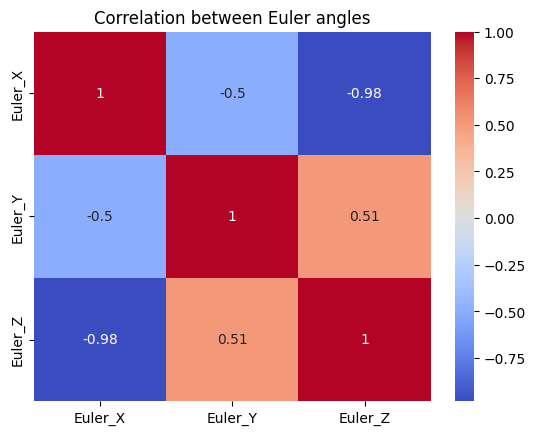

In [13]:
# Let's find the correlation between the Euler angles   
corr = df[['Euler_X', 'Euler_Y', 'Euler_Z']].corr()
print(corr)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Euler angles')
plt.show()

**Euler_X & Euler_Z** high negative correlation (when one angle goes up, the other goes down) which means if the pelvis tilts more forward, it tends to twist less, or vice versa<br>
**Euler_X & Euler_Y** moderate negative relationship between forward/backward tilt (X) and side-to-side tilt (Y). If an athlete tilts forward more than usual, they might slightly reduce dropping one hip lower/higher<br>
**Euler_Y & Euler_Z (+0.51)** As the pelvis tilts more to one side (Y), it also tends to twist (Z) in the same direction to some extent.

# Accelerations

**The peak accelerations (max values) can tell you how hard the athlete hits the ground.**

In [14]:
# let's find acceleration statistics    
df['Acc_X'] = pd.to_numeric(df['Acc_X'], errors='coerce')
df['Acc_Y'] = pd.to_numeric(df['Acc_Y'], errors='coerce')
df['Acc_Z'] = pd.to_numeric(df['Acc_Z'], errors='coerce')
print(df[['Acc_X', 'Acc_Y', 'Acc_Z']].describe())

            Acc_X       Acc_Y       Acc_Z
count  672.000000  672.000000  672.000000
mean     9.744938    0.117191    1.088022
std      5.866193    1.182763    3.067529
min    -17.715855  -10.045979   -7.115994
25%      9.774590    0.123954    0.462086
50%      9.808512    0.216319    0.527105
75%      9.839744    0.253115    0.961803
max     97.041138   11.857512   36.169914


In [15]:
acc_magnitude = np.sqrt(df["Acc_X"]**2 + df["Acc_Y"]**2 + df["Acc_Z"]**2)

acc_magnitude.describe()

count    672.000000
mean      10.330275
std        5.886588
min        0.000000
25%        9.806069
50%        9.830605
75%        9.868213
max      102.855957
dtype: float64

# Gyroscope

**A gyroscope in an IMU sensor measures angular velocity how fast (and in which direction)**

**Gyr_X: Rotation around the X-axis (e.g., forward/backward tilting speed).**

**Gyr_Y: Rotation around the Y-axis (side-to-side tilting speed).**

**Gyr_Z: Rotation around the Z-axis (twisting speed).**

In [16]:
# let's find thr statistics of the gyroscope    
df['Gyr_X'] = pd.to_numeric(df['Gyr_X'], errors='coerce')
df['Gyr_Y'] = pd.to_numeric(df['Gyr_Y'], errors='coerce')
df['Gyr_Z'] = pd.to_numeric(df['Gyr_Z'], errors='coerce')
print(df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']].describe())


            Gyr_X       Gyr_Y       Gyr_Z
count  672.000000  672.000000  672.000000
mean    -0.114339   -0.945516    0.231364
std     16.972732   30.346702    9.994962
min   -150.107513 -340.759583  -92.757011
25%     -0.593726   -1.925177    0.327521
50%      0.513163   -1.002334    0.675055
75%      1.202031   -0.237854    1.234028
max    104.568871  264.055389   54.046719


            Gyr_X     Gyr_Y     Gyr_Z     Acc_X     Acc_Y     Acc_Z   Euler_X  \
Gyr_X    1.000000  0.022368  0.073021 -0.339250 -0.160966 -0.200499  0.042922   
Gyr_Y    0.022368  1.000000 -0.116931 -0.158157  0.085517  0.254390 -0.000346   
Gyr_Z    0.073021 -0.116931  1.000000  0.014253  0.198004 -0.302241  0.038458   
Acc_X   -0.339250 -0.158157  0.014253  1.000000 -0.130161  0.402392 -0.050705   
Acc_Y   -0.160966  0.085517  0.198004 -0.130161  1.000000 -0.107368  0.185147   
Acc_Z   -0.200499  0.254390 -0.302241  0.402392 -0.107368  1.000000 -0.165442   
Euler_X  0.042922 -0.000346  0.038458 -0.050705  0.185147 -0.165442  1.000000   
Euler_Y -0.298204  0.045729 -0.260039  0.192837  0.009624  0.457560 -0.497659   
Euler_Z -0.035879  0.055358 -0.044625  0.035563 -0.161940  0.136230 -0.981369   

          Euler_Y   Euler_Z  
Gyr_X   -0.298204 -0.035879  
Gyr_Y    0.045729  0.055358  
Gyr_Z   -0.260039 -0.044625  
Acc_X    0.192837  0.035563  
Acc_Y    0.009624 -0.161940  
Acc_Z    

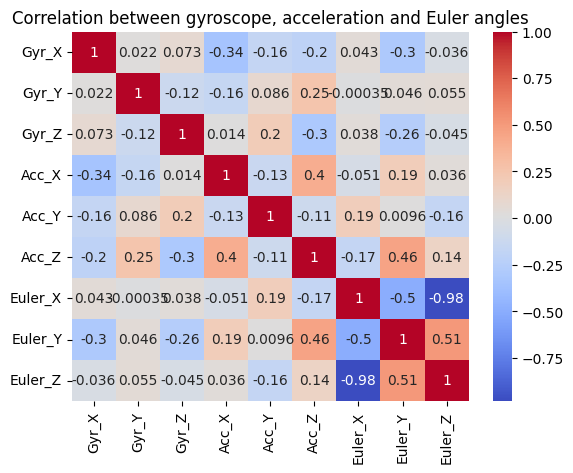

In [17]:
# Find the correlation between the gyroscope, acceleration  and Euler angles    
corr = df[['Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Euler_X', 'Euler_Y', 'Euler_Z']].corr()
print(corr)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between gyroscope, acceleration and Euler angles')
plt.show()

In [18]:
df.shape

(672, 16)